In [1]:
from qutip import*
import numpy as np
import scipy as sy
import time
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from scipy.integrate import odeint, complex_ode, ode

This code implements the influence martingale for a chain of coupled qubits.
The dynamics of the chain are described by a general time local master equation as desribed in https://arxiv.org/abs/2102.10355.
The qubits have Hamiltonian

$$H=\sum_{l=1}^{N} \sigma_{+}^{(l)}\sigma^{(l)}_{-} + \lambda \sum_{l=1}^{N-1}(\sigma^{(l)}_{+} \sigma^{(l+1)}_{-}+\sigma^{(l+1)}_{+} \sigma^{(l)}_{-})$$

and the master equation is of the form

$$\frac{d}{dt}\rho(t) = -i[H,\rho(t)] + \sum_{l=1}^{N} \Gamma_{l,t}(\sigma_{-}^{(l)}\rho(t)\sigma_{+}^{(l)}-\{ \sigma_{+}^{(l)}\sigma_{-}^{(l)},\rho(t)\})+ \sum_{l=1}^{N} \delta(\sigma_{+}^{(l)}\rho(t)\sigma_{-}^{(l)}-\{ \sigma_{-}^{(l)}\sigma_{+}^{(l)},\rho(t)\}) $$

where $\Gamma_{l,t}=\gamma>0$ for $l=2$ to $N$, $\delta>0$ and 

$$\Gamma_{1,t}=\kappa (n_{th}+1) - 12 \exp(-2 t^3)\sin^2(15t)$$

which can take negative values.

In [2]:
def SystSetup(M,kappa,nth):
    c_ops = []
    d_ops = []
    
    if M==1:
    ## 1 qubits
        a0=tensor(destroy(N))
        H=a0.dag()*a0  # Simple oscillator Hamiltonian
        psi0=tensor(basis(N,1))
        e_ops = [a0.dag() * a0, a0 * a0.dag()]
        c_ops.append([ a0, interval])
        c_ops.append([ a0.dag(), interval2])
        
        d_ops.append([lindblad_dissipator(a0,-a0),interval3])
        d_ops.append(np.sqrt(kappa * nth) * a0.dag())
        
    elif M==2:
    ## 2 qubits
        a0=tensor(destroy(N),qeye(N))
        a1=tensor(qeye(N),destroy(N))
        H=a0.dag()*a0 + a1.dag()*a1 + lambd * (a0.dag()*a1 + a1.dag()*a0)    # Simple oscillator Hamiltonian
        psi0=tensor(basis(N,1),basis(N,1))
        e_ops = [a0.dag() * a0, a0 * a0.dag(), a1.dag() * a1, a1 * a1.dag()]
        c_ops.append([ a0, interval])
        c_ops.append([ a0.dag(), interval2])
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a1)
        c_ops.append(np.sqrt(kappa * nth) * a1.dag())
        
        d_ops.append([lindblad_dissipator(a0,-a0),interval3])
        d_ops.append(np.sqrt(kappa * nth) * a0.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a1)
        d_ops.append(np.sqrt(kappa * nth) * a1.dag())

    elif M==3:
    ## 3 qubits
        a0=tensor(destroy(N),qeye(N),qeye(N))
        a1=tensor(qeye(N),destroy(N),qeye(N))
        a2=tensor(qeye(N),qeye(N),destroy(N))
        H=a0.dag()*a0 + a1.dag()*a1 + a2.dag()*a2\
        + lambd * (a0.dag()*a1 + a1.dag()*a0) + lambd * (a1.dag()*a2 + a2.dag()*a1)
        psi0=tensor(basis(N,1),basis(N,1),basis(N,1))
        e_ops = [a0.dag() * a0, a0 * a0.dag(), a1.dag() * a1, a1 * a1.dag(), a2.dag() * a2, a2 * a2.dag()]
        c_ops.append([ a0, interval])
        c_ops.append([a0.dag(), interval2])
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a1)
        c_ops.append(np.sqrt(kappa * nth) * a1.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a2)
        c_ops.append(np.sqrt(kappa * nth) * a2.dag())
        
        d_ops.append([lindblad_dissipator(a0,-a0),interval3])
        d_ops.append(np.sqrt(kappa * nth) * a0.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a1)
        d_ops.append(np.sqrt(kappa * nth) * a1.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a2)
        d_ops.append(np.sqrt(kappa * nth) * a2.dag())
    
    elif M==4:
    ## 4 qubits
        a0=tensor(destroy(N),qeye(N),qeye(N),qeye(N))
        a1=tensor(qeye(N),destroy(N),qeye(N),qeye(N))
        a2=tensor(qeye(N),qeye(N),destroy(N),qeye(N))
        a3=tensor(qeye(N),qeye(N),qeye(N),destroy(N))
        H=a0.dag()*a0 + a1.dag()*a1 + a2.dag()*a2 + a3.dag()*a3\
        + lambd * (a0.dag()*a1 + a1.dag()*a0) + lambd * (a1.dag()*a2 + a2.dag()*a1)+ lambd * (a2.dag()*a3+ a3.dag()*a2) 
        psi0=tensor(basis(N,1),basis(N,1),basis(N,1),basis(N,1))
        e_ops = [a0.dag() * a0, a0 * a0.dag(), a1.dag() * a1, a1 * a1.dag(), a2.dag() * a2, a2 * a2.dag(), a3.dag() * a3, a3 * a3.dag()]
        c_ops.append([a0, interval])
        c_ops.append([a0.dag(), interval2])
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a1)
        c_ops.append(np.sqrt(kappa * nth) * a1.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a2)
        c_ops.append(np.sqrt(kappa * nth) * a2.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a3)
        c_ops.append(np.sqrt(kappa * nth) * a3.dag())
        
        d_ops.append([lindblad_dissipator(a0,-a0),interval3])
        d_ops.append(np.sqrt(kappa * nth) * a0.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a1)
        d_ops.append(np.sqrt(kappa * nth) * a1.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a2)
        d_ops.append(np.sqrt(kappa * nth) * a2.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a3)
        d_ops.append(np.sqrt(kappa * nth) * a3.dag())

    elif M==5:
    ## 5 qubits
        a0=tensor(destroy(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a1=tensor(qeye(N),destroy(N),qeye(N),qeye(N),qeye(N))
        a2=tensor(qeye(N),qeye(N),destroy(N),qeye(N),qeye(N))
        a3=tensor(qeye(N),qeye(N),qeye(N),destroy(N),qeye(N))
        a4=tensor(qeye(N),qeye(N),qeye(N),qeye(N),destroy(N))
        H=a0.dag()*a0 + a1.dag()*a1 + a2.dag()*a2 + a3.dag()*a3 + a4.dag()*a4\
        + lambd * (a0.dag()*a1 + a1.dag()*a0) + lambd * (a1.dag()*a2 + a2.dag()*a1)+ lambd * (a2.dag()*a3+ a3.dag()*a2) + lambd * (a3.dag()*a4 + a4.dag()*a3)
        psi0=tensor(basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1))
        e_ops = [a0.dag() * a0, a0 * a0.dag(), a1.dag() * a1, a1 * a1.dag(), a2.dag() * a2, a2 * a2.dag(), a3.dag() * a3, a3 * a3.dag(), a4.dag() * a4, a4 * a4.dag()]
        c_ops.append([ a0, interval])
        c_ops.append([ a0.dag(), interval2])
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a1)
        c_ops.append(np.sqrt(kappa * nth) * a1.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a2)
        c_ops.append(np.sqrt(kappa * nth) * a2.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a3)
        c_ops.append(np.sqrt(kappa * nth) * a3.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a4)
        c_ops.append(np.sqrt(kappa * nth) * a4.dag())
        
        d_ops.append([lindblad_dissipator(a0,-a0),interval3])
        d_ops.append(np.sqrt(kappa * nth) * a0.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a1)
        d_ops.append(np.sqrt(kappa * nth) * a1.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a2)
        d_ops.append(np.sqrt(kappa * nth) * a2.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a3)
        d_ops.append(np.sqrt(kappa * nth) * a3.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a4)
        d_ops.append(np.sqrt(kappa * nth) * a4.dag())

    elif M==6:
    ## 6 qubits
        a0=tensor(destroy(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a1=tensor(qeye(N),destroy(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a2=tensor(qeye(N),qeye(N),destroy(N),qeye(N),qeye(N),qeye(N))
        a3=tensor(qeye(N),qeye(N),qeye(N),destroy(N),qeye(N),qeye(N))
        a4=tensor(qeye(N),qeye(N),qeye(N),qeye(N),destroy(N),qeye(N))
        a5=tensor(qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),destroy(N))
        H=a0.dag()*a0 + a1.dag()*a1 + a2.dag()*a2 + a3.dag()*a3 + a4.dag()*a4 + a5.dag()*a5\
        + lambd * (a0.dag()*a1 + a1.dag()*a0) + lambd * (a1.dag()*a2 + a2.dag()*a1)+ lambd * (a2.dag()*a3+ a3.dag()*a2) + lambd * (a3.dag()*a4 + a4.dag()*a3) + lambd * (a4.dag()*a5 + a5.dag()*a4)
        psi0=tensor(basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1))
        e_ops = [a0.dag() * a0, a0 * a0.dag(), a1.dag() * a1, a1 * a1.dag(), a2.dag() * a2, a2 * a2.dag(), a3.dag() * a3, a3 * a3.dag(), a4.dag() * a4, a4 * a4.dag()\
                ,a5.dag() * a5, a5 * a5.dag()]
        c_ops.append([a0, interval])
        c_ops.append([ a0.dag(), interval2])
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a1)
        c_ops.append(np.sqrt(kappa * nth) * a1.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a2)
        c_ops.append(np.sqrt(kappa * nth) * a2.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a3)
        c_ops.append(np.sqrt(kappa * nth) * a3.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a4)
        c_ops.append(np.sqrt(kappa * nth) * a4.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a5)
        c_ops.append(np.sqrt(kappa * nth) * a5.dag())
        
        d_ops.append([lindblad_dissipator(a0,-a0),interval3])
        d_ops.append(np.sqrt(kappa * nth) * a0.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a1)
        d_ops.append(np.sqrt(kappa * nth) * a1.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a2)
        d_ops.append(np.sqrt(kappa * nth) * a2.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a3)
        d_ops.append(np.sqrt(kappa * nth) * a3.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a4)
        d_ops.append(np.sqrt(kappa * nth) * a4.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a5)
        d_ops.append(np.sqrt(kappa * nth) * a5.dag())

    elif M==7:
    ## 7
        a0=tensor(destroy(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a1=tensor(qeye(N),destroy(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a2=tensor(qeye(N),qeye(N),destroy(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a3=tensor(qeye(N),qeye(N),qeye(N),destroy(N),qeye(N),qeye(N),qeye(N))
        a4=tensor(qeye(N),qeye(N),qeye(N),qeye(N),destroy(N),qeye(N),qeye(N))
        a5=tensor(qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),destroy(N),qeye(N))
        a6=tensor(qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),destroy(N))
        H=a0.dag()*a0 + a1.dag()*a1 + a2.dag()*a2 + a3.dag()*a3 + a4.dag()*a4 + a5.dag()*a5 + a6.dag()*a6 \
        + lambd * (a0.dag()*a1 + a1.dag()*a0) + lambd * (a1.dag()*a2 + a2.dag()*a1)+ lambd * (a2.dag()*a3+ a3.dag()*a2) + lambd * (a3.dag()*a4 + a4.dag()*a3) + lambd * (a4.dag()*a5 + a5.dag()*a4)\
        + lambd * (a5.dag()*a6 + a6.dag()*a5)
        psi0=tensor(basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1))
        e_ops = [a0.dag() * a0, a0 * a0.dag(), a1.dag() * a1, a1 * a1.dag(), a2.dag() * a2, a2 * a2.dag(), a3.dag() * a3, a3 * a3.dag(), a4.dag() * a4, a4 * a4.dag()\
                ,a5.dag() * a5, a5 * a5.dag(), a6.dag() * a6, a6 * a6.dag()]
        c_ops.append([a0, interval])
        c_ops.append([a0.dag(), interval2])
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a1)
        c_ops.append(np.sqrt(kappa * nth) * a1.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a2)
        c_ops.append(np.sqrt(kappa * nth) * a2.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a3)
        c_ops.append(np.sqrt(kappa * nth) * a3.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a4)
        c_ops.append(np.sqrt(kappa * nth) * a4.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a5)
        c_ops.append(np.sqrt(kappa * nth) * a5.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a6)
        c_ops.append(np.sqrt(kappa * nth) * a6.dag())
        
        d_ops.append([lindblad_dissipator(a0,-a0),interval3])
        d_ops.append(np.sqrt(kappa * nth) * a0.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a1)
        d_ops.append(np.sqrt(kappa * nth) * a1.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a2)
        d_ops.append(np.sqrt(kappa * nth) * a2.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a3)
        d_ops.append(np.sqrt(kappa * nth) * a3.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a4)
        d_ops.append(np.sqrt(kappa * nth) * a4.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a5)
        d_ops.append(np.sqrt(kappa * nth) * a5.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a6)
        d_ops.append(np.sqrt(kappa * nth) * a6.dag())

    elif M==8:
    ## 8
        a0=tensor(destroy(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a1=tensor(qeye(N),destroy(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a2=tensor(qeye(N),qeye(N),destroy(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a3=tensor(qeye(N),qeye(N),qeye(N),destroy(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a4=tensor(qeye(N),qeye(N),qeye(N),qeye(N),destroy(N),qeye(N),qeye(N),qeye(N))
        a5=tensor(qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),destroy(N),qeye(N),qeye(N))
        a6=tensor(qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),destroy(N),qeye(N))
        a7=tensor(qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),destroy(N))
        H=a0.dag()*a0 + a1.dag()*a1 + a2.dag()*a2 + a3.dag()*a3 + a4.dag()*a4 + a5.dag()*a5 + a6.dag()*a6 + a7.dag()*a7 \
        + lambd * (a0.dag()*a1 + a1.dag()*a0) + lambd * (a1.dag()*a2 + a2.dag()*a1)+ lambd * (a2.dag()*a3+ a3.dag()*a2) + lambd * (a3.dag()*a4 + a4.dag()*a3) + lambd * (a4.dag()*a5 + a5.dag()*a4)\
        + lambd * (a5.dag()*a6 + a6.dag()*a5) + lambd * (a6.dag()*a7 + a7.dag()*a6)
        psi0=tensor(basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1))
        e_ops = [a0.dag() * a0, a0 * a0.dag(), a1.dag() * a1, a1 * a1.dag(), a2.dag() * a2, a2 * a2.dag(), a3.dag() * a3, a3 * a3.dag(), a4.dag() * a4, a4 * a4.dag()\
                ,a5.dag() * a5, a5 * a5.dag(), a6.dag() * a6, a6 * a6.dag(), a7.dag() * a7, a7 * a7.dag()]
        c_ops.append([a0, interval])
        c_ops.append([a0.dag(), interval2])
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a1)
        c_ops.append(np.sqrt(kappa * nth) * a1.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a2)
        c_ops.append(np.sqrt(kappa * nth) * a2.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a3)
        c_ops.append(np.sqrt(kappa * nth) * a3.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a4)
        c_ops.append(np.sqrt(kappa * nth) * a4.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a5)
        c_ops.append(np.sqrt(kappa * nth) * a5.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a6)
        c_ops.append(np.sqrt(kappa * nth) * a6.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a7)
        c_ops.append(np.sqrt(kappa * nth) * a7.dag())

        d_ops.append([lindblad_dissipator(a0,-a0),interval3])
        d_ops.append(np.sqrt(kappa * nth) * a0.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a1)
        d_ops.append(np.sqrt(kappa * nth) * a1.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a2)
        d_ops.append(np.sqrt(kappa * nth) * a2.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a3)
        d_ops.append(np.sqrt(kappa * nth) * a3.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a4)
        d_ops.append(np.sqrt(kappa * nth) * a4.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a5)
        d_ops.append(np.sqrt(kappa * nth) * a5.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a6)
        d_ops.append(np.sqrt(kappa * nth) * a6.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a7)
        d_ops.append(np.sqrt(kappa * nth) * a7.dag())

    elif M==9:
    ## 9
        a0=tensor(destroy(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a1=tensor(qeye(N),destroy(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a2=tensor(qeye(N),qeye(N),destroy(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a3=tensor(qeye(N),qeye(N),qeye(N),destroy(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a4=tensor(qeye(N),qeye(N),qeye(N),qeye(N),destroy(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a5=tensor(qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),destroy(N),qeye(N),qeye(N),qeye(N))
        a6=tensor(qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),destroy(N),qeye(N),qeye(N))
        a7=tensor(qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),destroy(N),qeye(N))
        a8=tensor(qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),destroy(N))
        H=a0.dag()*a0 + a1.dag()*a1 + a2.dag()*a2 + a3.dag()*a3 + a4.dag()*a4 + a5.dag()*a5 + a6.dag()*a6 + a7.dag()*a7 + a8.dag()*a8 \
        + lambd * (a0.dag()*a1 + a1.dag()*a0) + lambd * (a1.dag()*a2 + a2.dag()*a1)+ lambd * (a2.dag()*a3+ a3.dag()*a2) + lambd * (a3.dag()*a4 + a4.dag()*a3) + lambd * (a4.dag()*a5 + a5.dag()*a4)\
        + lambd * (a5.dag()*a6 + a6.dag()*a5) + lambd * (a6.dag()*a7 + a7.dag()*a6)+ lambd * (a7.dag()*a8+ a8.dag()*a7) 
        psi0=tensor(basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1))
        e_ops = [a0.dag() * a0, a0 * a0.dag(), a1.dag() * a1, a1 * a1.dag(), a2.dag() * a2, a2 * a2.dag(), a3.dag() * a3, a3 * a3.dag(), a4.dag() * a4, a4 * a4.dag()\
                ,a5.dag() * a5, a5 * a5.dag(), a6.dag() * a6, a6 * a6.dag(), a7.dag() * a7, a7 * a7.dag(), a8.dag() * a8, a8 * a8.dag()]
        c_ops.append([a0, interval])
        c_ops.append([a0.dag(), interval2])
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a1)
        c_ops.append(np.sqrt(kappa * nth) * a1.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a2)
        c_ops.append(np.sqrt(kappa * nth) * a2.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a3)
        c_ops.append(np.sqrt(kappa * nth) * a3.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a4)
        c_ops.append(np.sqrt(kappa * nth) * a4.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a5)
        c_ops.append(np.sqrt(kappa * nth) * a5.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a6)
        c_ops.append(np.sqrt(kappa * nth) * a6.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a7)
        c_ops.append(np.sqrt(kappa * nth) * a7.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a8)
        c_ops.append(np.sqrt(kappa * nth) * a8.dag())

        d_ops.append([lindblad_dissipator(a0,-a0),interval3])
        d_ops.append(np.sqrt(kappa * nth) * a0.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a1)
        d_ops.append(np.sqrt(kappa * nth) * a1.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a2)
        d_ops.append(np.sqrt(kappa * nth) * a2.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a3)
        d_ops.append(np.sqrt(kappa * nth) * a3.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a4)
        d_ops.append(np.sqrt(kappa * nth) * a4.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a5)
        d_ops.append(np.sqrt(kappa * nth) * a5.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a6)
        d_ops.append(np.sqrt(kappa * nth) * a6.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a7)
        d_ops.append(np.sqrt(kappa * nth) * a7.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a8)
        d_ops.append(np.sqrt(kappa * nth) * a8.dag())

    elif M==10:
    ##10
        a0=tensor(destroy(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a1=tensor(qeye(N),destroy(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a2=tensor(qeye(N),qeye(N),destroy(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a3=tensor(qeye(N),qeye(N),qeye(N),destroy(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a4=tensor(qeye(N),qeye(N),qeye(N),qeye(N),destroy(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a5=tensor(qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),destroy(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a6=tensor(qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),destroy(N),qeye(N),qeye(N),qeye(N))
        a7=tensor(qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),destroy(N),qeye(N),qeye(N))
        a8=tensor(qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),destroy(N),qeye(N))
        a9=tensor(qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),destroy(N))
        H=a0.dag()*a0 + a1.dag()*a1 + a2.dag()*a2 + a3.dag()*a3 + a4.dag()*a4 + a5.dag()*a5 + a6.dag()*a6 + a7.dag()*a7 + a8.dag()*a8 + a9.dag()*a9\
        + lambd * (a0.dag()*a1 + a1.dag()*a0) + lambd * (a1.dag()*a2 + a2.dag()*a1)+ lambd * (a2.dag()*a3+ a3.dag()*a2) + lambd * (a3.dag()*a4 + a4.dag()*a3) + lambd * (a4.dag()*a5 + a5.dag()*a4)\
        + lambd * (a5.dag()*a6 + a6.dag()*a5) + lambd * (a6.dag()*a7 + a7.dag()*a6)+ lambd * (a7.dag()*a8+ a8.dag()*a7) + lambd * (a8.dag()*a9 + a9.dag()*a8) 
        psi0=tensor(basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1))
        e_ops = [a0.dag() * a0, a0 * a0.dag(), a1.dag() * a1, a1 * a1.dag(), a2.dag() * a2, a2 * a2.dag(), a3.dag() * a3, a3 * a3.dag(), a4.dag() * a4, a4 * a4.dag()\
                ,a5.dag() * a5, a5 * a5.dag(), a6.dag() * a6, a6 * a6.dag(), a7.dag() * a7, a7 * a7.dag(), a8.dag() * a8, a8 * a8.dag(), a9.dag() * a9, a9 * a9.dag()]
        c_ops.append([a0, interval])
        c_ops.append([a0.dag(), interval2])
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a1)
        c_ops.append(np.sqrt(kappa * nth) * a1.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a2)
        c_ops.append(np.sqrt(kappa * nth) * a2.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a3)
        c_ops.append(np.sqrt(kappa * nth) * a3.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a4)
        c_ops.append(np.sqrt(kappa * nth) * a4.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a5)
        c_ops.append(np.sqrt(kappa * nth) * a5.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a6)
        c_ops.append(np.sqrt(kappa * nth) * a6.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a7)
        c_ops.append(np.sqrt(kappa * nth) * a7.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a8)
        c_ops.append(np.sqrt(kappa * nth) * a8.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a9)
        c_ops.append(np.sqrt(kappa * nth) * a9.dag())
        
        d_ops.append([lindblad_dissipator(a0,-a0),interval3])
        d_ops.append(np.sqrt(kappa * nth) * a0.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a1)
        d_ops.append(np.sqrt(kappa * nth) * a1.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a2)
        d_ops.append(np.sqrt(kappa * nth) * a2.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a3)
        d_ops.append(np.sqrt(kappa * nth) * a3.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a4)
        d_ops.append(np.sqrt(kappa * nth) * a4.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a5)
        d_ops.append(np.sqrt(kappa * nth) * a5.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a6)
        d_ops.append(np.sqrt(kappa * nth) * a6.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a7)
        d_ops.append(np.sqrt(kappa * nth) * a7.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a8)
        d_ops.append(np.sqrt(kappa * nth) * a8.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a9)
        d_ops.append(np.sqrt(kappa * nth) * a9.dag())

    elif M==11:
    ## 11 qubits
        a0=tensor(destroy(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a1=tensor(qeye(N),destroy(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a2=tensor(qeye(N),qeye(N),destroy(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a3=tensor(qeye(N),qeye(N),qeye(N),destroy(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a4=tensor(qeye(N),qeye(N),qeye(N),qeye(N),destroy(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a5=tensor(qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),destroy(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a6=tensor(qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),destroy(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a7=tensor(qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),destroy(N),qeye(N),qeye(N),qeye(N))
        a8=tensor(qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),destroy(N),qeye(N),qeye(N))
        a9=tensor(qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),destroy(N),qeye(N))
        a10=tensor(qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),destroy(N))
        H=a0.dag()*a0 + a1.dag()*a1 + a2.dag()*a2 + a3.dag()*a3 + a4.dag()*a4 + a5.dag()*a5 + a6.dag()*a6 + a7.dag()*a7 + a8.dag()*a8 + a9.dag()*a9 + a10.dag()*a10\
        + lambd * (a0.dag()*a1 + a1.dag()*a0) + lambd * (a1.dag()*a2 + a2.dag()*a1)+ lambd * (a2.dag()*a3+ a3.dag()*a2) + lambd * (a3.dag()*a4 + a4.dag()*a3) + lambd * (a4.dag()*a5 + a5.dag()*a4)\
        + lambd * (a5.dag()*a6 + a6.dag()*a5) + lambd * (a6.dag()*a7 + a7.dag()*a6)+ lambd * (a7.dag()*a8+ a8.dag()*a7) + lambd * (a8.dag()*a9 + a9.dag()*a8) + lambd * (a9.dag()*a10 + a10.dag()*a9)
        psi0=tensor(basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1))
        e_ops = [a0.dag() * a0, a0 * a0.dag(), a1.dag() * a1, a1 * a1.dag(), a2.dag() * a2, a2 * a2.dag(), a3.dag() * a3, a3 * a3.dag(), a4.dag() * a4, a4 * a4.dag()\
                ,a5.dag() * a5, a5 * a5.dag(), a6.dag() * a6, a6 * a6.dag(), a7.dag() * a7, a7 * a7.dag(), a8.dag() * a8, a8 * a8.dag(), a9.dag() * a9, a9 * a9.dag()\
                ,a10.dag() * a10, a10 * a10.dag()]
        c_ops.append([a0, interval])
        c_ops.append([a0.dag(), interval2])
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a1)
        c_ops.append(np.sqrt(kappa * nth) * a1.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a2)
        c_ops.append(np.sqrt(kappa * nth) * a2.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a3)
        c_ops.append(np.sqrt(kappa * nth) * a3.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a4)
        c_ops.append(np.sqrt(kappa * nth) * a4.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a5)
        c_ops.append(np.sqrt(kappa * nth) * a5.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a6)
        c_ops.append(np.sqrt(kappa * nth) * a6.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a7)
        c_ops.append(np.sqrt(kappa * nth) * a7.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a8)
        c_ops.append(np.sqrt(kappa * nth) * a8.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a9)
        c_ops.append(np.sqrt(kappa * nth) * a9.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a10)
        c_ops.append(np.sqrt(kappa * nth) * a10.dag())

        d_ops.append([lindblad_dissipator(a0,-a0),interval3])
        d_ops.append(np.sqrt(kappa * nth) * a0.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a1)
        d_ops.append(np.sqrt(kappa * nth) * a1.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a2)
        d_ops.append(np.sqrt(kappa * nth) * a2.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a3)
        d_ops.append(np.sqrt(kappa * nth) * a3.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a4)
        d_ops.append(np.sqrt(kappa * nth) * a4.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a5)
        d_ops.append(np.sqrt(kappa * nth) * a5.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a6)
        d_ops.append(np.sqrt(kappa * nth) * a6.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a7)
        d_ops.append(np.sqrt(kappa * nth) * a7.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a8)
        d_ops.append(np.sqrt(kappa * nth) * a8.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a9)
        d_ops.append(np.sqrt(kappa * nth) * a9.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a10)
        d_ops.append(np.sqrt(kappa * nth) * a10.dag())

    elif M==12:
    ## 12 qubits
        a0=tensor(destroy(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a1=tensor(qeye(N),destroy(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a2=tensor(qeye(N),qeye(N),destroy(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a3=tensor(qeye(N),qeye(N),qeye(N),destroy(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a4=tensor(qeye(N),qeye(N),qeye(N),qeye(N),destroy(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a5=tensor(qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),destroy(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a6=tensor(qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),destroy(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a7=tensor(qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),destroy(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a8=tensor(qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),destroy(N),qeye(N),qeye(N),qeye(N))
        a9=tensor(qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),destroy(N),qeye(N),qeye(N))
        a10=tensor(qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),destroy(N),qeye(N))
        a11=tensor(qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),destroy(N))
        H=a0.dag()*a0 + a1.dag()*a1 + a2.dag()*a2 + a3.dag()*a3 + a4.dag()*a4 + a5.dag()*a5 + a6.dag()*a6 + a7.dag()*a7 + a8.dag()*a8 + a9.dag()*a9 + a10.dag()*a10+ a11.dag()*a11\
        + lambd * (a0.dag()*a1 + a1.dag()*a0) + lambd * (a1.dag()*a2 + a2.dag()*a1)+ lambd * (a2.dag()*a3+ a3.dag()*a2) + lambd * (a3.dag()*a4 + a4.dag()*a3) + lambd * (a4.dag()*a5 + a5.dag()*a4)\
        + lambd * (a5.dag()*a6 + a6.dag()*a5) + lambd * (a6.dag()*a7 + a7.dag()*a6)+ lambd * (a7.dag()*a8+ a8.dag()*a7) + lambd * (a8.dag()*a9 + a9.dag()*a8) + lambd * (a9.dag()*a10 + a10.dag()*a9)\
        + lambd * (a10.dag()*a11 + a11.dag()*a10)
        e_ops = [a0.dag() * a0, a0 * a0.dag(), a1.dag() * a1, a1 * a1.dag(), a2.dag() * a2, a2 * a2.dag(), a3.dag() * a3, a3 * a3.dag(), a4.dag() * a4, a4 * a4.dag()\
                ,a5.dag() * a5, a5 * a5.dag(), a6.dag() * a6, a6 * a6.dag(), a7.dag() * a7, a7 * a7.dag(), a8.dag() * a8, a8 * a8.dag(), a9.dag() * a9, a9 * a9.dag()\
                ,a10.dag() * a10, a10 * a10.dag(), a11.dag() * a11, a11 * a11.dag()]
        psi0=tensor(basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1))
        c_ops.append([a0, interval])
        c_ops.append([a0.dag(), interval2])
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a1)
        c_ops.append(np.sqrt(kappa * nth) * a1.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a2)
        c_ops.append(np.sqrt(kappa * nth) * a2.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a3)
        c_ops.append(np.sqrt(kappa * nth) * a3.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a4)
        c_ops.append(np.sqrt(kappa * nth) * a4.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a5)
        c_ops.append(np.sqrt(kappa * nth) * a5.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a6)
        c_ops.append(np.sqrt(kappa * nth) * a6.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a7)
        c_ops.append(np.sqrt(kappa * nth) * a7.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a8)
        c_ops.append(np.sqrt(kappa * nth) * a8.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a9)
        c_ops.append(np.sqrt(kappa * nth) * a9.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a10)
        c_ops.append(np.sqrt(kappa * nth) * a10.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a11)
        c_ops.append(np.sqrt(kappa * nth) * a11.dag())

        d_ops.append([lindblad_dissipator(a0,-a0),interval3])
        d_ops.append(np.sqrt(kappa * nth) * a0.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a1)
        d_ops.append(np.sqrt(kappa * nth) * a1.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a2)
        d_ops.append(np.sqrt(kappa * nth) * a2.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a3)
        d_ops.append(np.sqrt(kappa * nth) * a3.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a4)
        d_ops.append(np.sqrt(kappa * nth) * a4.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a5)
        d_ops.append(np.sqrt(kappa * nth) * a5.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a6)
        d_ops.append(np.sqrt(kappa * nth) * a6.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a7)
        d_ops.append(np.sqrt(kappa * nth) * a7.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a8)
        d_ops.append(np.sqrt(kappa * nth) * a8.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a9)
        d_ops.append(np.sqrt(kappa * nth) * a9.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a10)
        d_ops.append(np.sqrt(kappa * nth) * a10.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a11)
        d_ops.append(np.sqrt(kappa * nth) * a11.dag())
        
    elif M==13:
    ## 13 qubits
        a0=tensor(destroy(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a1=tensor(qeye(N),destroy(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a2=tensor(qeye(N),qeye(N),destroy(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a3=tensor(qeye(N),qeye(N),qeye(N),destroy(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a4=tensor(qeye(N),qeye(N),qeye(N),qeye(N),destroy(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a5=tensor(qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),destroy(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a6=tensor(qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),destroy(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a7=tensor(qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),destroy(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a8=tensor(qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),destroy(N),qeye(N),qeye(N),qeye(N),qeye(N))
        a9=tensor(qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),destroy(N),qeye(N),qeye(N),qeye(N))
        a10=tensor(qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),destroy(N),qeye(N),qeye(N))
        a11=tensor(qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),destroy(N),qeye(N))
        a12=tensor(qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N),destroy(N))
        H=a0.dag()*a0 + a1.dag()*a1 + a2.dag()*a2 + a3.dag()*a3 + a4.dag()*a4 + a5.dag()*a5 + a6.dag()*a6 + a7.dag()*a7 + a8.dag()*a8 + a9.dag()*a9 + a10.dag()*a10+ a11.dag()*a11+ a12.dag()*a12\
        + lambd * (a0.dag()*a1 + a1.dag()*a0) + lambd * (a1.dag()*a2 + a2.dag()*a1)+ lambd * (a2.dag()*a3+ a3.dag()*a2) + lambd * (a3.dag()*a4 + a4.dag()*a3) + lambd * (a4.dag()*a5 + a5.dag()*a4)\
        + lambd * (a5.dag()*a6 + a6.dag()*a5) + lambd * (a6.dag()*a7 + a7.dag()*a6)+ lambd * (a7.dag()*a8+ a8.dag()*a7) + lambd * (a8.dag()*a9 + a9.dag()*a8) + lambd * (a9.dag()*a10 + a10.dag()*a9)\
        + lambd * (a10.dag()*a11 + a11.dag()*a10)+ lambd * (a11.dag()*a12 + a12.dag()*a11)
        e_ops = [a0.dag() * a0, a0 * a0.dag(), a1.dag() * a1, a1 * a1.dag(), a2.dag() * a2, a2 * a2.dag(), a3.dag() * a3, a3 * a3.dag(), a4.dag() * a4, a4 * a4.dag()\
                ,a5.dag() * a5, a5 * a5.dag(), a6.dag() * a6, a6 * a6.dag(), a7.dag() * a7, a7 * a7.dag(), a8.dag() * a8, a8 * a8.dag(), a9.dag() * a9, a9 * a9.dag()\
                ,a10.dag() * a10, a10 * a10.dag(), a11.dag() * a11, a11 * a11.dag(), a12 * a12.dag()]
        psi0=tensor(basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1),basis(N,1))
        c_ops.append([a0, interval])
        c_ops.append([a0.dag(), interval2])
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a1)
        c_ops.append(np.sqrt(kappa * nth) * a1.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a2)
        c_ops.append(np.sqrt(kappa * nth) * a2.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a3)
        c_ops.append(np.sqrt(kappa * nth) * a3.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a4)
        c_ops.append(np.sqrt(kappa * nth) * a4.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a5)
        c_ops.append(np.sqrt(kappa * nth) * a5.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a6)
        c_ops.append(np.sqrt(kappa * nth) * a6.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a7)
        c_ops.append(np.sqrt(kappa * nth) * a7.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a8)
        c_ops.append(np.sqrt(kappa * nth) * a8.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a9)
        c_ops.append(np.sqrt(kappa * nth) * a9.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a10)
        c_ops.append(np.sqrt(kappa * nth) * a10.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a11)
        c_ops.append(np.sqrt(kappa * nth) * a11.dag())
        c_ops.append(np.sqrt(kappa * (1 + nth)) * a12)
        c_ops.append(np.sqrt(kappa * nth) * a12.dag())
        
        d_ops.append([lindblad_dissipator(a0,-a0),interval3])
        d_ops.append(np.sqrt(kappa * nth) * a0.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a1)
        d_ops.append(np.sqrt(kappa * nth) * a1.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a2)
        d_ops.append(np.sqrt(kappa * nth) * a2.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a3)
        d_ops.append(np.sqrt(kappa * nth) * a3.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a4)
        d_ops.append(np.sqrt(kappa * nth) * a4.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a5)
        d_ops.append(np.sqrt(kappa * nth) * a5.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a6)
        d_ops.append(np.sqrt(kappa * nth) * a6.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a7)
        d_ops.append(np.sqrt(kappa * nth) * a7.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a8)
        d_ops.append(np.sqrt(kappa * nth) * a8.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a9)
        d_ops.append(np.sqrt(kappa * nth) * a9.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a10)
        d_ops.append(np.sqrt(kappa * nth) * a10.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a11)
        d_ops.append(np.sqrt(kappa * nth) * a11.dag())
        d_ops.append(np.sqrt(kappa * (1 + nth)) * a12)
        d_ops.append(np.sqrt(kappa * nth) * a12.dag())
    else: 
        print('Amount of Qubits not implemented')
    return c_ops, d_ops, e_ops, psi0, H
#psi0=tensor(basis(N,1),basis(N,1))# Initial Fock state with one photon

In [3]:
## Here we define the different coefficient functions to implement the martingale and the corresponding master equation
## interval and interval2 are the jump rates for the stochastic schrodinger equation. interval is for \sigma_- and interval2 for \sigma_+.
## interval3 is -\Gamma_{1,t} (see above), the weight factor appearing in the master equation for \sigma_- 
def interval(t, args):  # coefficient function
    return np.sqrt((12*np.exp(-2*t**3)*(-np.sin(15*t)**2)+1.0/0.129*(0.063+1))\
                   +Martingale_Weight(t,args)/(1-Martingale_Weight(t,args))*1.0/0.129*0.063)
def interval2(t, args):  # coefficient function
    return np.sqrt(1/(1-Martingale_Weight(t,args))*1.0/0.129*0.063)
def interval3(t, args):  # coefficient function
    return -(12*np.exp(-2*t**3)*(-np.sin(15*t)**2)+1.0/0.129*(0.063+1))

In [4]:
## we have the defined the martingale weight factor such that \Gamma_{1,2}=interval(tlist, None)**2 -Martingale_Weight(tlist, None)*interval2(tlist, None)**2
## and \kappa n_th = interval2(tlist, None)**2 -Martingale_Weight(tlist, None)*interval2(tlist, None)**2
def Martingale_Weight(t,args):
    s=(1+np.sign(interval3(t, args)))/2*(1+interval3(t, args)/(interval3(t, args)+1.0/0.129*0.063))/2
    return s

In [5]:
## Define the parameters of the simulation
kappa=1.0/0.129 # Coupling rate to heat bath
nth= 0.063      # Temperature with <n>=0.063
N=2
lambd=10
ntraj = 1000 # number of MC trajectories
tlist = np.linspace(0,1,101)

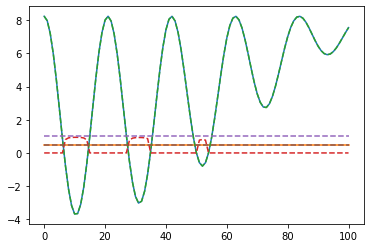

In [6]:
#check whether all rate functions are defined consitently
plt.plot(interval(tlist, None)**2 -Martingale_Weight(tlist, None)*interval2(tlist, None)**2) 
plt.plot(interval2(tlist, None)**2 -Martingale_Weight(tlist, None)*interval2(tlist, None)**2)
plt.plot(-interval3(tlist, None),'--')
plt.plot(Martingale_Weight(tlist, None),'--')
plt.plot(np.zeros(101)+1,'--')
plt.plot(kappa*nth*(np.zeros(101)+1),'--')

Let the influence martingale evolve as 

$$d\mu_t = -c_t \mu_t + \mu_t(\Gamma_{1,t}/r_{1,t}-1) d\nu_{1,t}+ \mu_t(\kappa n_{th}/r_{2,t}-1) d\nu_{2,t}$$

where in our case $-c_t=$ Martingale_Weight(tlist, None)*interval2(tlist, None)^2 >0 
and 
$r_{1,t}$ = interval(tlist, None)^2, $r_{2,t}$ = interval2(tlist, None)^2

The influence martingale evolution can be written as the product of two terms

$$\mu_t = \exp\bigg(-\int_0^t ds\, c_s\bigg) \prod_j \frac{\Gamma_{k_j,t_j}}{r_{k_j,t_j}}$$

where the product runs over all jumps made by the operators acting on site 1.

In [7]:
##Functions to implement the influence martingale
def mu_cont(tlist,args): # compute the continuous part of the martingale evolution
    s=np.ones(len(tlist))
    ss=0
    for jj in range(1,len(tlist)):
        # We  compute the time integral for every interval and sum them together
        ss +=sy.integrate.quad(lambda t: Martingale_Weight(t,args) * interval2(t, args)**2,tlist[jj-1], tlist[jj])[0]
        s[jj] = np.exp(ss)
    return s
def calc(t,sig,args): #compute contribution for an individual jump
    if sig==0:
        s = 1 - Martingale_Weight(t,args) * interval2(t, args)**2 / interval(t, args)**2
    elif sig==1:
        s = 1 - Martingale_Weight(t,args)
    else:
        s = 1 
    return s
def mu_jump(J_list,J_which,args): #Function to compute the jump contributions to the martingale
    #Compute a vector with factors due to jumps
    s = np.zeros(len(J_list))
    for j in range(0,len(J_list)):
        s[j] = calc(J_list[j], J_which[j], args)
    
    #The vector s may contain several jumps that happened during the same time interval [tlist[j-1],tlist[j]]. All jumps in this time interval should be accounted for at time tlist[j].
    #The vector S will be the actual output, where this is taken into account.
    index = np.zeros(len(J_list))
    S = np.ones(len(tlist))
    for jj in range(0,len(J_list)):
        #Index contains the closest time in tlist to which the jump happened. however if t_jump>tlist[index[jj]] we need to shift the index to jj+1 
        index[jj] = np.argmin(np.abs(tlist-J_list[jj]))
        if tlist[index[jj].astype(int)] - J_list[jj] <0:
            index[jj] += 1
    #Combine all elememts s to the right places index in S
    for j in range(0,len(index)):
            S[index[j].astype(int):] *= s[j]
    return S

In [8]:
#initialise the system
c_ops, d_ops, e_ops, psi0, H = SystSetup(3,kappa,nth)

In [9]:
#Generate trajectories for the state vector
start = timer()
opts = Options(average_expect = False)
MCSol = mcsolve(H, psi0, tlist, c_ops, e_ops, ntraj,options = opts)
end = timer()
print(end-start)

10.0%. Run time:   1.02s. Est. time left: 00:00:00:09
20.0%. Run time:   1.90s. Est. time left: 00:00:00:07
30.0%. Run time:   2.83s. Est. time left: 00:00:00:06
40.0%. Run time:   3.74s. Est. time left: 00:00:00:05
50.0%. Run time:   4.60s. Est. time left: 00:00:00:04
60.0%. Run time:   5.43s. Est. time left: 00:00:00:03
70.0%. Run time:   6.29s. Est. time left: 00:00:00:02
80.0%. Run time:   7.12s. Est. time left: 00:00:00:01
90.0%. Run time:   7.94s. Est. time left: 00:00:00:00
100.0%. Run time:   8.75s. Est. time left: 00:00:00:00
Total run time:   8.75s
8.790056125000001


In [10]:
#solve the master equation
end = timer()
MESol = mesolve(H, psi0, tlist, d_ops, e_ops, progress_bar = True)
end2 = timer()
print(end2-end)

10.9%. Run time:   0.00s. Est. time left: 00:00:00:00
20.8%. Run time:   0.00s. Est. time left: 00:00:00:00
30.7%. Run time:   0.00s. Est. time left: 00:00:00:00
40.6%. Run time:   0.00s. Est. time left: 00:00:00:00
50.5%. Run time:   0.01s. Est. time left: 00:00:00:00
60.4%. Run time:   0.01s. Est. time left: 00:00:00:00
70.3%. Run time:   0.01s. Est. time left: 00:00:00:00
80.2%. Run time:   0.01s. Est. time left: 00:00:00:00
90.1%. Run time:   0.01s. Est. time left: 00:00:00:00
Total run time:   0.01s
0.019255541999999792


0.2369956249999987


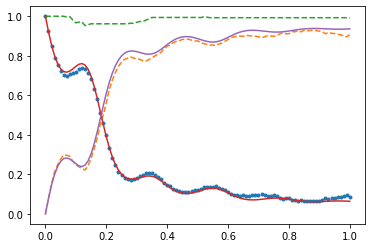

In [11]:
##Here we will implement the martingale
start = timer()
#the continuous part of the martingale is the same for every realisation, so we precompute it
Mu = mu_cont(tlist,None)
#some vectors to store things
Muu = np.zeros(len(tlist))
Expect = np.zeros([ntraj,len(tlist),len(e_ops)])
for j in range(0,ntraj):
    #compute the martingale and call it lala
    lala = mu_jump(MCSol.col_times[j],MCSol.col_which[j],None) * Mu 
    
    #Muu is the sum of the influence martingale for all trajectories. Muu/ntraj should average to 1
    Muu += lala
    #compute the expectation values of all observables
    for jj in range(0,len(e_ops)):
        Expect[j,:,jj] = lala * MCSol.expect[j][jj]
end = timer()
print(end-start)
#Compute Errors
ERR = np.zeros([len(tlist),len(e_ops)])
for j in range(0,len(tlist)):
    for jj in range(0,len(e_ops)):
        ERR[j,jj]=np.sum((MESol.expect[jj][j]-Expect[:,j,jj])**2)**(1/2)/ntraj
        
# Plot the different expectation values and divide them by the amount of trajectories ntraj
plt.plot(tlist,np.sum(Expect[:,:,0],axis=0)/ntraj,'.')
plt.plot(tlist,np.sum(Expect[:,:,1],axis=0)/ntraj,'--')

# Alternatively, one could define the exectations by Muu which would normalise the trace
# of the density matrix to 1 
plt.plot(tlist,Muu/ntraj,'--')

# Plot the expectation values computed by solving the master equation directly.
plt.plot(tlist,MESol.expect[0])
plt.plot(tlist,MESol.expect[1])

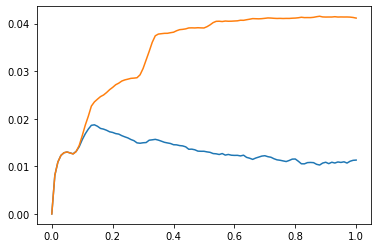

In [12]:
#Compute the errors
ERRup = np.zeros([len(tlist),2])
ERRdown = np.zeros([len(tlist),2])
ERRup[:,0]=tlist
ERRdown[:,0]=tlist
for j in range(0,int(len(e_ops)/2)):
    ERRup[:,1] += ERR[:,2*j]/(len(e_ops)/2)
    ERRdown[:,1] += ERR[:,2*j+1]/(len(e_ops)/2)
plt.plot(ERRup[:,0],ERRup[:,1])
plt.plot(ERRdown[:,0],ERRdown[:,1])

In [13]:
Site0_Up=np.zeros([len(tlist),2])
Site0_Do=np.zeros([len(tlist),2])
Site4_Up=np.zeros([len(tlist),2])
Site4_Do=np.zeros([len(tlist),2])
Site11_Up=np.zeros([len(tlist),2])
Site11_Do=np.zeros([len(tlist),2])

Soll0_Up=np.zeros([len(tlist),2])
Soll0_Do=np.zeros([len(tlist),2])
Soll4_Up=np.zeros([len(tlist),2])
Soll4_Do=np.zeros([len(tlist),2])
Soll11_Up=np.zeros([len(tlist),2])
Soll11_Do=np.zeros([len(tlist),2])


Site0_Up[:,0] = tlist 
Site0_Up[:,1] = np.sum(Expect[:,:,0],axis=0)/ntraj/(Muu/1000)
Site0_Do[:,0] = tlist 
Site0_Do[:,1] = np.sum(Expect[:,:,1],axis=0)/ntraj/(Muu/1000)
Site4_Up[:,0] = tlist 
Site4_Up[:,1] = np.sum(Expect[:,:,2],axis=0)/ntraj/(Muu/1000)
Site4_Do[:,0] = tlist 
Site4_Do[:,1] = np.sum(Expect[:,:,3],axis=0)/ntraj/(Muu/1000)
Site11_Up[:,0] = tlist 
Site11_Up[:,1] = np.sum(Expect[:,:,20],axis=0)/ntraj/(Muu/1000)
Site11_Do[:,0] = tlist 
Site11_Do[:,1] = np.sum(Expect[:,:,21],axis=0)/ntraj/(Muu/1000)

Soll0_Up[:,0] = tlist 
Soll0_Up[:,1] = MESol.expect[0]
Soll0_Do[:,0] = tlist 
Soll0_Do[:,1] = MESol.expect[1]
Soll4_Up[:,0] = tlist 
Soll4_Up[:,1] = MESol.expect[2]
Soll4_Do[:,0] = tlist 
Soll4_Do[:,1] = MESol.expect[3]
Soll11_Up[:,0] = tlist 
Soll11_Up[:,1] = MESol.expect[20]
Soll11_Do[:,0] = tlist 
Soll11_Do[:,1] = MESol.expect[21]

IndexError: index 20 is out of bounds for axis 2 with size 6

In [ ]:
plt.plot(Site0_Up[:,0],Site0_Up[:,1])
plt.plot(Site0_Up[:,0],Site0_Do[:,1])
plt.plot(Site0_Up[:,0],Site4_Up[:,1])
plt.plot(Site0_Up[:,0],Site4_Do[:,1])
plt.plot(Site0_Up[:,0],Site11_Up[:,1])
plt.plot(Site0_Up[:,0],Site11_Do[:,1])
plt.plot(tlist,MESol.expect[0])
plt.plot(tlist,MESol.expect[1])
plt.plot(tlist,MESol.expect[2])
plt.plot(tlist,MESol.expect[3])
plt.plot(tlist,MESol.expect[20])
plt.plot(tlist,MESol.expect[21])